In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [7]:
# This is where we load the data from our VIX.csv file and preprocess it
data_path = 'VIX.csv'
vix_data = pd.read_csv(data_path)
vix_values = vix_data['VIX'].values.reshape(-1, 1)


#scaling the data
scaler = MinMaxScaler()
vix_values_scaled = scaler.fit_transform(vix_values)
train_dataset = tf.data.Dataset.from_tensor_slices(vix_values_scaled).shuffle(len(vix_values_scaled)).batch(32)

In [8]:
#Here are our generator and discriminator models with an attention layer inside
def make_generator_model():
    noise_input = Input(shape=(100,))
    x = layers.Dense(256)(noise_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((16, 32))(x)
    query_value = layers.Dense(32)(x)
    attention_output = layers.Attention()([query_value, query_value])
    x = layers.Flatten()(attention_output)

    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Dense(2048)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    out = layers.Dense(1, activation='tanh')(x)
    model = Model(inputs=noise_input, outputs=out)
    return model

def make_discriminator_model():
    real_input = Input(shape=(1,))
    x = layers.Dense(4096)(real_input)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(2048)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Reshape((32, 64))(x)
    query_value = layers.Dense(64)(x)
    attention_output = layers.Attention()([query_value, query_value]) # attention layer
    x = layers.Flatten()(attention_output)

    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(512)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(1)(x)
    model = Model(inputs=real_input, outputs=out)
    return model

#this is using the wasserstein loss too (distance)

def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = Adam(1e-4) #Using the adam optimizer with 10 ^-4 learning rate
discriminator_optimizer = Adam(1e-4)

#Training step function
def train_step(real_data):
    noise = tf.random.normal([32, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_data, generated_data, gen_loss.numpy(), disc_loss.numpy()

# Training function, and at the end, we plot real v/s fake data at the last epoch from 0 to 20 index just
# so we can visualize better, we can keep changing this to visualize the generated data over the whole index range

def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    metric_diff = []
    for epoch in range(epochs):
        epoch_gen_losses = []
        epoch_disc_losses = []
        real_samples = []
        fake_samples = []

        for real_data in dataset:
            real_data, generated_data, gen_loss, disc_loss = train_step(real_data)
            real_samples.extend(real_data.numpy())
            fake_samples.extend(generated_data.numpy())
            epoch_gen_losses.append(gen_loss)
            epoch_disc_losses.append(disc_loss)

        gen_losses.append(np.mean(epoch_gen_losses))
        disc_losses.append(np.mean(epoch_disc_losses))
        metric_diff.append(np.mean(real_samples) - np.mean(fake_samples))

        print(f"Epoch {epoch+1}, Gen Loss: {gen_losses[-1]}, Disc Loss: {disc_losses[-1]}, Metric Diff: {metric_diff[-1]}")

#We're using the metric difference to compare models as the mean between the real and generated data!


    # Plotting generator and discriminator losses here
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    display_start_index = 0  # Start index of the sample to display
    display_end_index = 20  # End index of the sample to display

    #We've chosen an arbitrary start and stop index because it makes visual inspection easier,
    #because our goal is to find the model which can generated data the best (as similar to the real data as possible)

    plt.figure(figsize=(12, 6))
    plt.plot(real_samples[display_start_index:display_end_index], label='Real Data', alpha=0.7)
    plt.plot(fake_samples[display_start_index:display_end_index], label='Fake Data', alpha=0.7, linestyle='--')
    plt.title('Real vs. Fake Data at the Last Epoch')
    plt.xlabel('Sample Index')
    plt.ylabel('Scaled VIX Value')
    plt.savefig('Real_vs_Fake_Data_Last_Epoch.png')

    plt.legend()
    plt.show()

Epoch 1, Gen Loss: 10.775418281555176, Disc Loss: -9.043484687805176, Metric Diff: -0.0012227034026681682
Epoch 2, Gen Loss: 1925.8853759765625, Disc Loss: -1597.986083984375, Metric Diff: -0.037268209999233415
Epoch 3, Gen Loss: 57743.7109375, Disc Loss: -53409.9140625, Metric Diff: -0.046587262099414994
Epoch 4, Gen Loss: 694507.125, Disc Loss: -671395.3125, Metric Diff: -0.07755715007129305
Epoch 5, Gen Loss: 4946208.0, Disc Loss: -4813765.0, Metric Diff: -0.04056831056419005
Epoch 6, Gen Loss: 22926856.0, Disc Loss: -22763064.0, Metric Diff: 0.004668008739322493
Epoch 7, Gen Loss: 75411472.0, Disc Loss: -75828888.0, Metric Diff: 0.01596209054645903
Epoch 8, Gen Loss: 203083904.0, Disc Loss: -210870528.0, Metric Diff: 0.05332718437370662
Epoch 9, Gen Loss: 460189280.0, Disc Loss: -495867840.0, Metric Diff: 0.013712208921283525
Epoch 10, Gen Loss: 934110080.0, Disc Loss: -1025443200.0, Metric Diff: -0.006928045099407365
Epoch 11, Gen Loss: 1624830208.0, Disc Loss: -1851233024.0, Metr

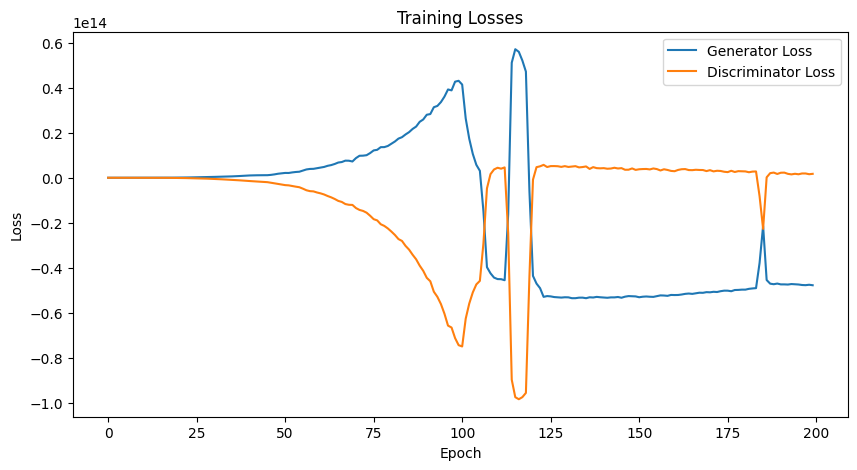

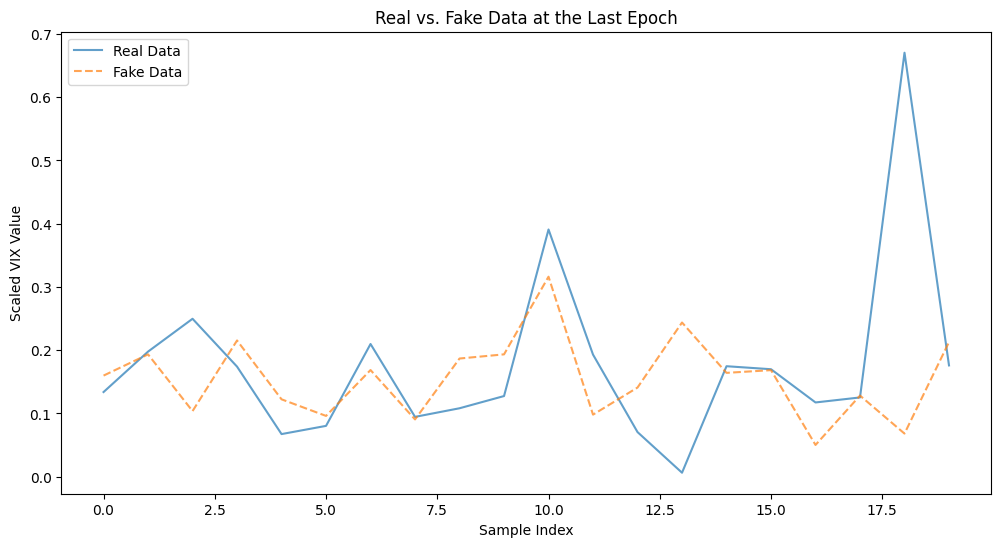

In [4]:
# Start Training
train(train_dataset, epochs=200)